# 📋 Churn Analysis

**✍️ Project Description and plan**

**📌 Research Objective**
- Analyze customer retention and churn patterns using available time-based and behavioral data.
- Identify temporal trends in churn using `tenure` as a proxy for customer lifecycle stage.
- Understand which customer segments are more prone to churn.

---

**📊 Data Description**
**Source:** *Telco Customer Churn dataset*

**The dataset includes:**
- **Churn status**: `Churn` column
- **Customer services**:
  - Phone service, multiple lines, internet service, online security, backup, device protection, tech support, streaming TV, streaming movies
- **Account details**:
  - `tenure` (in months), `contract` type, `payment method`, `monthly charges`, `total charges`, `paperless billing`
- **Demographics**:
  - `gender`, `senior citizen`, `partner`, `dependents`

---

**🧩 Cohort Definition**

Since the contract start date is not available, we will define cohorts using the `tenure` feature (the number of months a customer has been with the company).

The cohorts are defined as follows:

- **New Customers**: Customers with a tenure of 0 to 3 months
- **Early Adopters**: Customers with a tenure of 4 to 6 months
- **Settling Customers**: Customers with a tenure of 7 to 12 months
- **Established Users**: Customers with a tenure of 13 to 24 months
- **Loyal Customers**: Customers with a tenure of 25 months or more

This segmentation helps approximate customer lifecycle stages in the absence of actual service start dates.

---

**📈 Analysis Methodology**

- Create churn summaries **per tenure cohort**
- Calculate:
  - **Churn Rate** = % of customers who left
- Analyze churn in relation to:
  - Senior citizen type and gender
  - Phone & Internet service
  - Partner and Dependets
  - Additional Services
  - Contract type and payment methods
  - Feature Correlation
  - Feature Importance

---

**🔍 Interpretation of Results**

- Identify critical churn periods (e.g., first 6 months of service)
- Discover stable vs. high-risk cohorts
- Evaluate impact of features:
- Identify and explain churn drivers for vulnerable segments

---

**🧠 Conclusion**

- Summarize key insights on churn and retention
- Recommend strategies to improve retention:
  - Incentives for early-stage customers
  - Promoting longer contracts
  - Targeting at-risk demographics with personalized offers
- Suggest next steps:


## 🧑‍🔬 Analysis


### 🔍 Exploratory Data Analysis

In [34]:
# Core Libraries
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Machine Learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Suppress warnings
import warnings
warnings.filterwarnings("ignore", message="scipy._lib.messagestream.MessageStream size changed")

In [2]:
# Load dataset (adjust the path as needed)
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
df.shape

(7043, 21)

In [4]:
# We see that the column names are inconsistent — some are in uppercase, others in lowercase. Adjust them for consistency.
df.columns = df.columns.str.lower()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerid        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   seniorcitizen     7043 non-null   int64  
 3   partner           7043 non-null   object 
 4   dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   phoneservice      7043 non-null   object 
 7   multiplelines     7043 non-null   object 
 8   internetservice   7043 non-null   object 
 9   onlinesecurity    7043 non-null   object 
 10  onlinebackup      7043 non-null   object 
 11  deviceprotection  7043 non-null   object 
 12  techsupport       7043 non-null   object 
 13  streamingtv       7043 non-null   object 
 14  streamingmovies   7043 non-null   object 
 15  contract          7043 non-null   object 
 16  paperlessbilling  7043 non-null   object 


In [5]:
# rename columns
df.rename(columns={
    'customerid': 'customer_id',
    'seniorcitizen': 'senior_citizen',
    'phoneservice': 'phone_service',
    'multiplelines': 'multiple_lines',
    'internetservice': 'internet_service',
    'onlinesecurity': 'online_security',
    'onlinebackup': 'online_backup',
    'deviceprotection': 'device_protection',
    'techsupport': 'tech_support',
    'streamingtv': 'streaming_tv',
    'streamingmovies': 'streaming_movies',
    'paperlessbilling': 'paperless_billing',
    'paymentmethod': 'payment_method',
    'monthlycharges': 'monthly_charges',
    'totalcharges': 'total_charges'
}, inplace=True)


In [6]:
# change data types for numeric columns
df['total_charges'] = pd.to_numeric(df['total_charges'] , errors = 'coerce')
df['total_charges'].isnull().sum()
df.dropna(inplace=True)  # inplace to assure the change happens on the original dataframe

In [7]:
# Check duplicates
df.duplicated().sum()

0

**Observe distribution of numerical features**

In [8]:
# Observe distribution of numerical columns
df.describe().T

,count,mean,std,min,25%,50%,75%,max
senior_citizen,7032.0,0.162400,0.368844,0.00,0.0000,0.000,0.0000,1.00
tenure,7032.0,32.421786,24.545260,1.00,9.0000,29.000,55.0000,72.00
monthly_charges,7032.0,64.798208,30.085974,18.25,35.5875,70.350,89.8625,118.75
total_charges,7032.0,2283.300441,2266.771362,18.80,401.4500,1397.475,3794.7375,8684.80


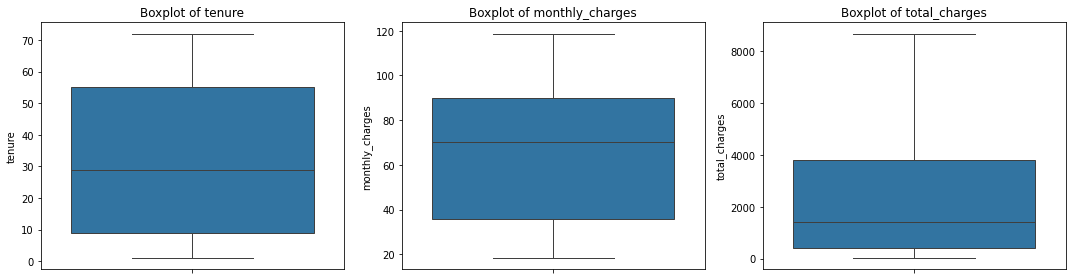

In [9]:
# Box plot chart of numeric columns
columns = ['tenure', 'monthly_charges', 'total_charges']

# Grid layout settings
n_cols = 3  # Number of plots per row
n_rows = (len(columns) + n_cols - 1) // n_cols  # Calculate number of rows needed

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))

# If only one row, axes might not be a 1D array
if n_rows == 1:
    axes = axes.reshape(-1)

# Plot each boxplot
for i, col in enumerate(columns):
    sns.boxplot(y=df[col], ax=axes[i])
    axes[i].set_title(f"Boxplot of {col}")

# Remove unused subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout to avoid overlapping
plt.tight_layout()
plt.show()


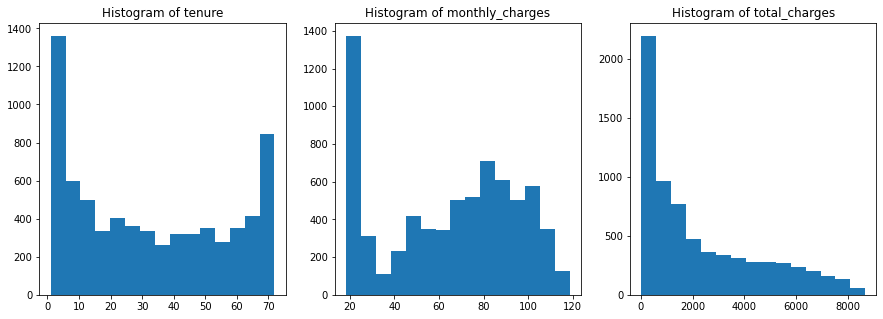

In [10]:
#Histogram chart of numeric columns

plt.figure(figsize=(15,5))
for i , col in enumerate(columns , start=1):
    plt.subplot(1,3 , i)
    plt.hist(df[col] , bins= 15)
    plt.title(f"Histogram of {col}")
    
plt.show()

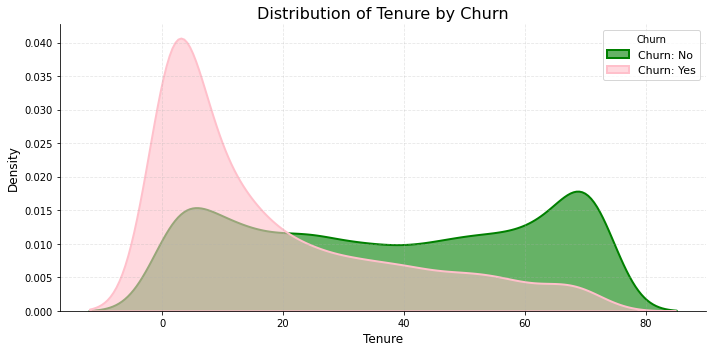

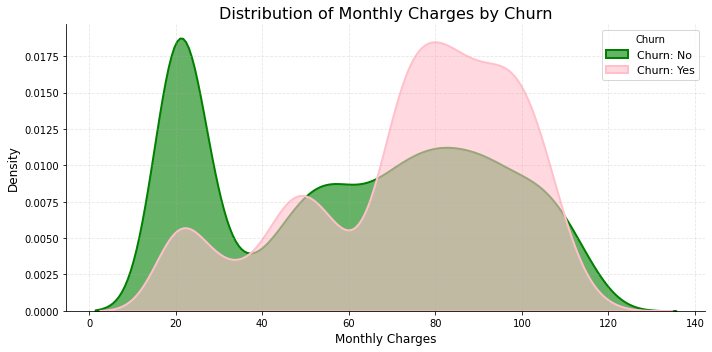

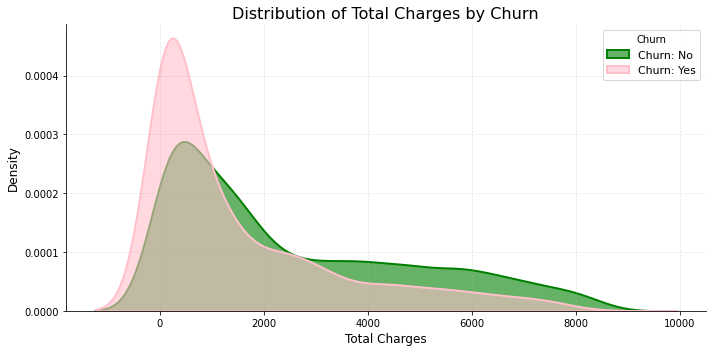

In [11]:
def kdeplot(feature):
    plt.figure(figsize=(10, 5))
    plt.title(f'Distribution of {feature.replace("_", " ").title()} by Churn', fontsize=16)
    
    # KDE for Churn: No
    sns.kdeplot(
        data=df[df['churn'] == 'No'],
        x=feature,
        fill=True,
        common_norm=False,
        alpha=0.6,
        linewidth=2,
        label='Churn: No',
        color='green'
    )
    
    # KDE for Churn: Yes
    sns.kdeplot(
        data=df[df['churn'] == 'Yes'],
        x=feature,
        fill=True,
        common_norm=False,
        alpha=0.6,
        linewidth=2,
        label='Churn: Yes',
        color='pink'
    )

    plt.xlabel(feature.replace("_", " ").title(), fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.legend(title='Churn', fontsize=11)
    plt.grid(True, linestyle='--', alpha=0.3)
    sns.despine()
    plt.tight_layout()
    plt.show()

# Example usage:
kdeplot('tenure')
kdeplot('monthly_charges')
kdeplot('total_charges')


From the plots above we can conclude that:

- Recent clients are more likely to churn
- Clients with higher MonthlyCharges are also more likely to churn
- Tenure and MonthlyCharges are probably important features

**Observe distribution of categorical feature**

In [12]:
def plot_categorical_distributions_with_stacked_churn(df, col, target='churn'):
    # Group and calculate counts and percentages
    data = (
        df.groupby([col, target])
          .size()
          .reset_index(name='count')
    )
    total_per_category = data.groupby(col)['count'].transform('sum')
    data['percent'] = (data['count'] / total_per_category * 100).round(1)

    # Pivot for stacked bar chart
    pivot_df = data.pivot(index=col, columns=target, values='count').fillna(0)

    # Create plot
    fig, ax = plt.subplots(figsize=(10, 6))
    pivot_df.plot(kind='bar', stacked=True,
                  color=['#90EE90', 'pink'], edgecolor='black', ax=ax)

    # Add annotations (larger, bold text)
    for i, category in enumerate(pivot_df.index):
        bottom = 0
        for churn_status in pivot_df.columns:
            count = pivot_df.loc[category, churn_status]
            if count == 0:
                continue
            percent = (count / pivot_df.loc[category].sum()) * 100
            if percent >= 1:
                ax.text(
                    i,
                    bottom + count / 2,
                    f'{int(count)}\n({percent:.1f}%)',
                    ha='center',
                    va='center',
                    fontsize=12,
                    fontweight='bold',
                    color='black'
                )
            bottom += count

    # Format label names
    col_label = col.replace("_", " ").title()
    target_label = target.replace("_", " ").title()

    # Set title: Churn by Gender, etc.
    ax.set_title(f'{target_label} by {col_label}', fontsize=18, weight='bold')
    ax.set_xlabel(col_label, fontsize=14)
    ax.set_ylabel('Customer Count', fontsize=14)
    ax.legend(title=target_label, loc='upper right', fontsize=12, title_fontsize=13)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()




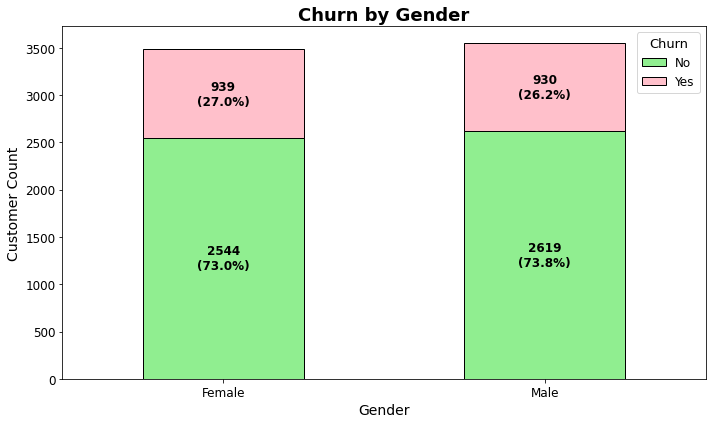

In [13]:
plot_categorical_distributions_with_stacked_churn(df, 'gender')


**Gender is not an indicative of churn.**

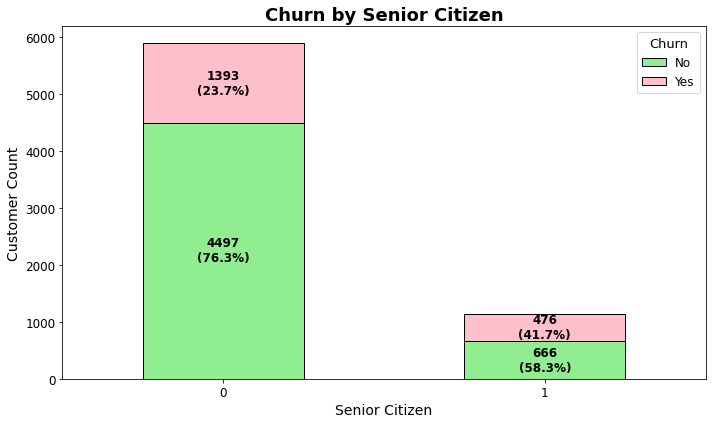

In [14]:
plot_categorical_distributions_with_stacked_churn(df, 'senior_citizen')


**SeniorCitizens are only 16% of customers, but they have a much higher churn rate: 42% against 23% for non-senior customers.**

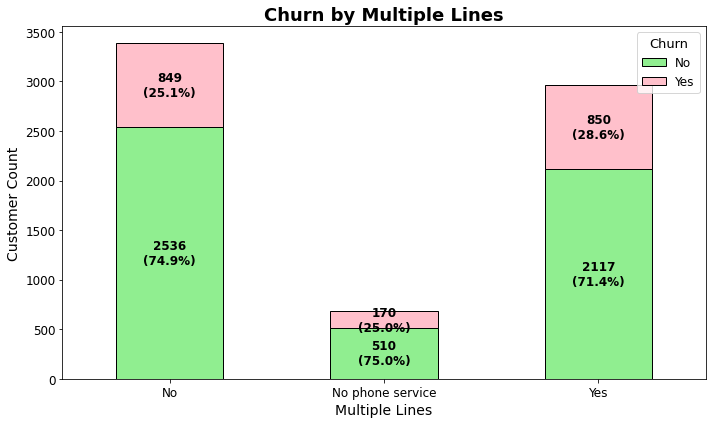

In [15]:
plot_categorical_distributions_with_stacked_churn(df, 'multiple_lines')


**Few customers doesn't have phone service.Customers with multiple lines have a slightly higher churn rate. Let's see how multiple lines affects the monthly charges:**

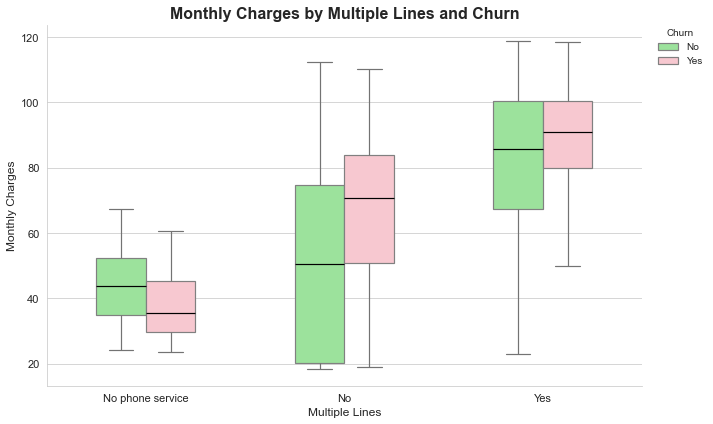

In [16]:
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Boxplot with minimalist styling
ax = sns.boxplot(
    x="multiple_lines",
    y="monthly_charges",
    hue="churn",
    data=df,
    palette={"Yes": "pink", "No": "#90EE90"},
    width=0.5,
    fliersize=0,
    linewidth=1.2,
    boxprops=dict(edgecolor='gray'),
    medianprops=dict(color='black')
)

# Remove duplicate legend entries
handles, labels = ax.get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))
ax.legend(
    unique_labels.values(),
    unique_labels.keys(),
    title="Churn",
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    borderaxespad=0,
    frameon=False
)

# Styling
ax.set_title("Monthly Charges by Multiple Lines and Churn", fontsize=16, fontweight='bold')
ax.set_xlabel("Multiple Lines", fontsize=12)
ax.set_ylabel("Monthly Charges", fontsize=12)
ax.tick_params(axis='both', labelsize=11)

sns.despine()
plt.tight_layout()
plt.show()


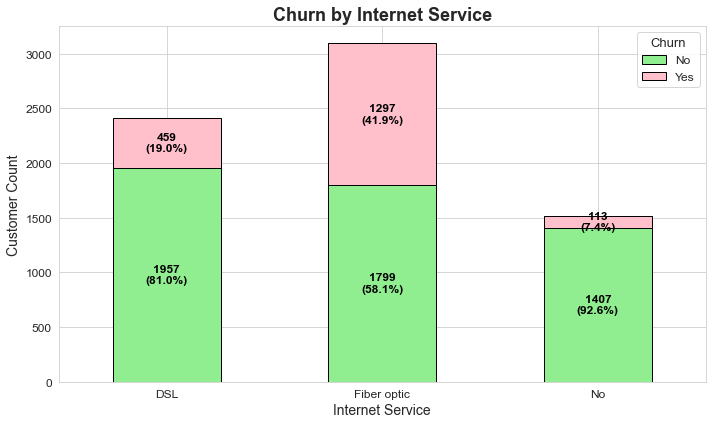

In [17]:
plot_categorical_distributions_with_stacked_churn(df, 'internet_service')

**Clients without internet have a very low churn rate. Customers with fiber are more probable to churn than those with DSL connection**

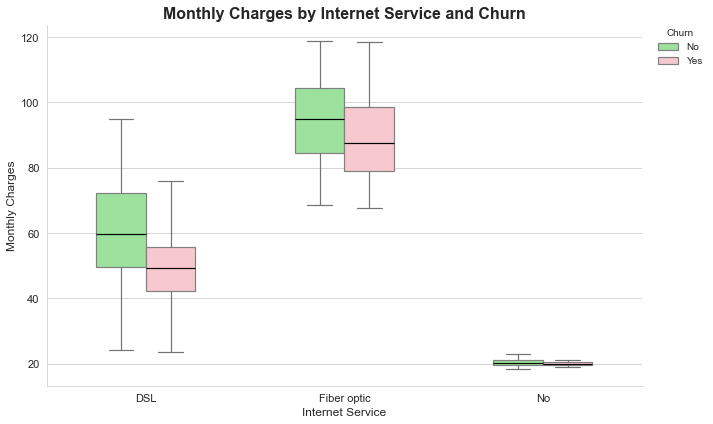

In [18]:
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Boxplot with tighter design
ax = sns.boxplot(
    x="internet_service",
    y="monthly_charges",
    hue="churn",
    data=df,
    palette={"Yes": "pink", "No": "#90EE90"},
    width=0.5,
    fliersize=0,
    linewidth=1.2,
    boxprops=dict(edgecolor='gray'),
    medianprops=dict(color='black')
)

# De-duplicate legend
handles, labels = ax.get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))
ax.legend(
    unique_labels.values(),
    unique_labels.keys(),
    title="Churn",
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    borderaxespad=0,
    frameon=False
)

# Formatting
ax.set_title("Monthly Charges by Internet Service and Churn", fontsize=16, fontweight='bold')
ax.set_xlabel("Internet Service", fontsize=12)
ax.set_ylabel("Monthly Charges", fontsize=12)
ax.tick_params(axis='both', labelsize=11)

sns.despine()
plt.tight_layout()
plt.show()


**It’s interesting to observe that customers using DSL (a slower internet connection) with higher monthly charges are less likely to churn. This suggests that low-demand segments tend to remain with their existing service plans, possibly due to satisfaction with basic needs being met or a lower sensitivity to performance.**

**There are six additional services for customers with internet:**

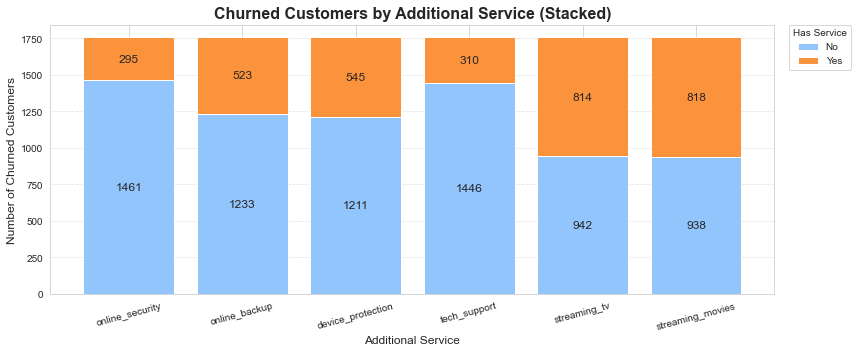

In [19]:
# Filter churned customers with internet
df1 = df[(df["internet_service"] != "No") & (df["churn"] == "Yes")]

# Prepare data
cols = ["online_security", "online_backup", "device_protection", "tech_support", "streaming_tv", "streaming_movies"]
df_melted = pd.melt(df1[cols], var_name="Service", value_name="Has service")

# Count values
counts = df_melted.groupby(["Service", "Has service"]).size().unstack(fill_value=0)
counts = counts.reindex(index=cols)

# Plot setup
plt.figure(figsize=(12, 5))
x = counts.index
bottom_vals = counts['No']
top_vals = counts['Yes']

# Stacked bars
bar1 = plt.bar(x, bottom_vals, label='No', color='#93C5FD')
bar2 = plt.bar(x, top_vals, bottom=bottom_vals, label='Yes', color='#FB923C')

# Annotations
for i in range(len(x)):
    if bottom_vals.iloc[i] > 0:
        plt.text(i, bottom_vals.iloc[i] / 2, str(bottom_vals.iloc[i]), ha='center', va='center', fontsize=12)
    if top_vals.iloc[i] > 0:
        plt.text(i, bottom_vals.iloc[i] + top_vals.iloc[i] / 2, str(top_vals.iloc[i]), ha='center', va='center', fontsize=12)

# Labels and title
plt.title("Churned Customers by Additional Service (Stacked)", fontsize=16, fontweight='bold')
plt.xlabel("Additional Service", fontsize=12)
plt.ylabel("Number of Churned Customers", fontsize=12)
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Legend outside the plot
plt.legend(title="Has Service", bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

plt.tight_layout()
plt.show()


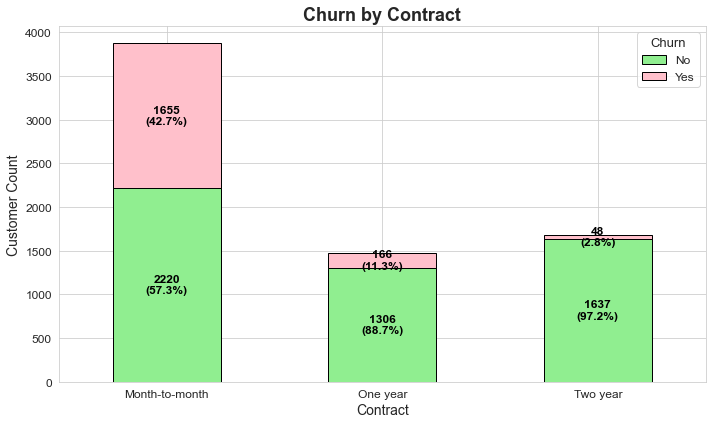

In [20]:
plot_categorical_distributions_with_stacked_churn(df, 'contract')

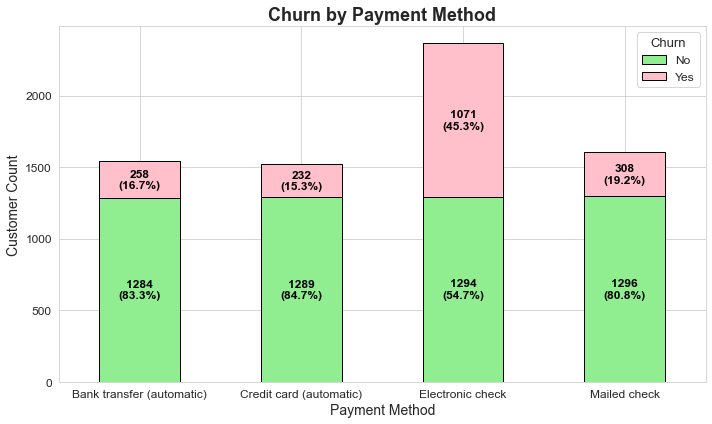

In [21]:
plot_categorical_distributions_with_stacked_churn(df, 'payment_method')

A few observations:

- Customers with paperless billing are more probable to churn
- One and two year contracts probably have contractual fines and therefore customers have to wait untill the end of contract to churn. A time-series dataset would be better to understand this kind of behaviour. Now let's have a look at the relation with numerical features:

**EDA Conclusions**

1. 🔑 Key Behavioral Patterns:
- Recent customers are more likely to churn, indicating low initial retention.
- Higher monthly charges are strongly associated with increased churn.
- Both tenure and monthly charges appear to be important predictors of churn.

2. 👥 Demographics:
- Gender does not influence churn.
- Senior Citizens, although only 16% of the customer base, have a churn rate of 42%—almost double that of non-seniors (23%).

3. 📞 Phone Services:
- Almost all customers have phone service.
- Customers with multiple lines show a slightly higher churn rate.
- However, their monthly charges are also higher, which could partially explain that behavior.

4. 🌐 Internet Service & Additional Services:
- Customers without internet churn very little.
- Among internet users:
    - Fiber users churn more than DSL users, likely due to higher costs.
    - Interestingly, DSL users with higher charges churn less, suggesting low-demand customers may be less sensitive to price/performance shifts.
- The six additional services (e.g., online security, backup, streaming) reveal:
    - Fewer additional services correlate with higher churn.
    - Streaming services (TV and Movies) have the highest counts of churned users with services enabled, showing that entertainment-focused users are more prone to leave.

5. 💳 Billing & Contract Type:
- Paperless billing customers churn more frequently—possibly linked to self-service or online management preferences.
- One and two-year contracts reduce churn, likely due to cancellation fees or lock-ins.
- A time-series or subscription-lifecycle dataset would better capture this dynamic.

### 🧩 Cohort Analysis

**make cohorts and analyse the distribution**

In [22]:
# Define the cohort assignment function
def assign_cohort(tenure):
    if 0 <= tenure <= 3:
        return 'New Customers'
    elif 4 <= tenure <= 6:
        return 'Early Adopters'
    elif 7 <= tenure <= 12:
        return 'Settling Customers'
    elif 13 <= tenure <= 24:
        return 'Established Users'
    else:
        return 'Loyal Customers'

# Apply the function to create a new column
df['cohort'] = df['tenure'].apply(assign_cohort)


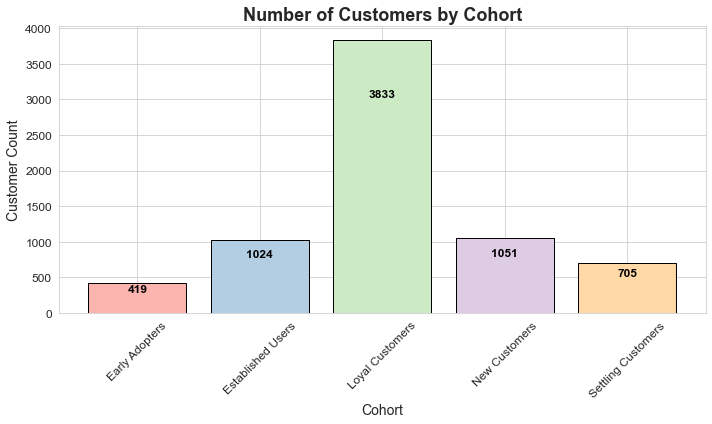

In [24]:
# Prepare data
cohort_counts = df['cohort'].value_counts().reset_index()
cohort_counts.columns = ['cohort', 'count']

# Sort by cohort if needed
cohort_counts = cohort_counts.sort_values('cohort')

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(
    cohort_counts['cohort'],
    cohort_counts['count'],
    color=plt.cm.Pastel1.colors,  # Mimic colorful Plotly palette
    edgecolor='black'
)

# Add text labels inside bars
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height * 0.8,  # position inside bar (90% height)
        f'{int(height)}',
        ha='center',
        va='center',
        fontsize=12,
        fontweight='bold',
        color='black'
    )

# Formatting
ax.set_title('Number of Customers by Cohort', fontsize=18, weight='bold')
ax.set_xlabel('Cohort', fontsize=14)
ax.set_ylabel('Customer Count', fontsize=14)
ax.tick_params(axis='x', labelrotation=45, labelsize=12)
ax.tick_params(axis='y', labelsize=12)
plt.tight_layout()
plt.show()


- Loyal Customers – Stable and likely to stay.
- New Customers – Recently joined and more prone to churn.
- Established Users – Building loyalty but still at risk.
- Settling Customers – Adjusting to the service, moderately stable.
- Early Adopters – Tech-forward users, possibly less committed.

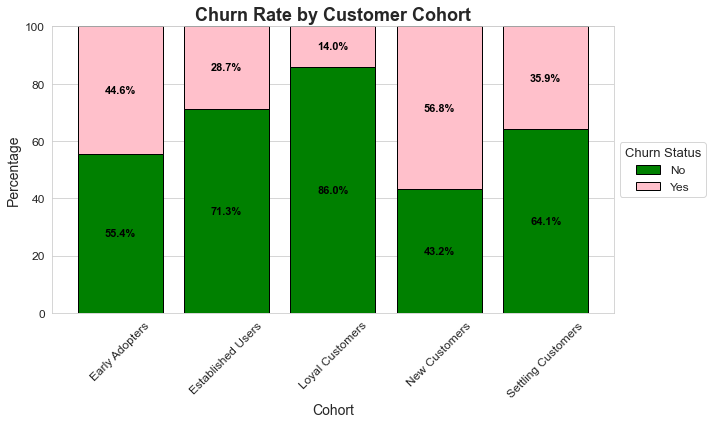

In [25]:
# Group by cohort and churn, count occurrences
churn_by_cohort = df.groupby(['cohort', 'churn']).size().reset_index(name='count')

# Calculate percent within each cohort using transform (no warning)
churn_by_cohort['percent'] = churn_by_cohort.groupby('cohort')['count'].transform(
    lambda x: (100 * x / x.sum()).round(2)
)

# Pivot for stacked bar chart
pivot = churn_by_cohort.pivot(index='cohort', columns='churn', values='percent').fillna(0)

# Ensure columns order if both exist
pivot = pivot[['No', 'Yes']] if 'No' in pivot.columns and 'Yes' in pivot.columns else pivot

# Plot setup
fig, ax = plt.subplots(figsize=(10, 6))

bottom = np.zeros(len(pivot))  # baseline for stacked bars
colors = {'No': 'green', 'Yes': 'pink'}

# Plot bars stacked by churn status
for churn_status in pivot.columns:
    values = pivot[churn_status].values
    bars = ax.bar(
        pivot.index,
        values,
        bottom=bottom,
        label=churn_status,
        color=colors.get(churn_status, 'gray'),
        edgecolor='black'
    )
    
    # Add value labels inside bars where >=1%
    for i, (bar, val) in enumerate(zip(bars, values)):
        if val >= 1:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bottom[i] + val / 2,
                f'{val:.1f}%',
                ha='center',
                va='center',
                fontsize=11,
                fontweight='bold',
                color='black'
            )
    bottom += values  # update baseline for next stacked bars

# Final touches
ax.set_title('Churn Rate by Customer Cohort', fontsize=18, weight='bold')
ax.set_xlabel('Cohort', fontsize=14)
ax.set_ylabel('Percentage', fontsize=14)
ax.set_ylim(0, 100)
ax.tick_params(axis='x', labelrotation=45, labelsize=12)
ax.tick_params(axis='y', labelsize=12)

# Legend outside plot on right
ax.legend(
    title='Churn Status',
    fontsize=12,
    title_fontsize=13,
    loc='center left',
    bbox_to_anchor=(1, 0.5)
)

plt.tight_layout()
plt.show()


**Insight: Churn decreases as customer loyalty increases, with the most loyal cohorts showing the lowest churn rates.**

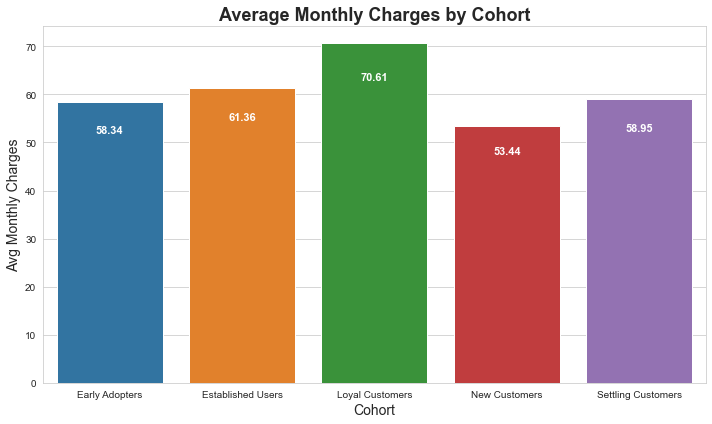

In [26]:
avg_revenue = df.groupby('cohort')['monthly_charges'].mean().round(2).reset_index()

plt.figure(figsize=(10, 6))

# Use hue='cohort' to assign colors per cohort and palette to control colors
barplot = sns.barplot(data=avg_revenue, x='cohort', y='monthly_charges', hue='cohort', palette='tab10', dodge=False)

# Add text labels inside bars
for index, row in avg_revenue.iterrows():
    barplot.text(
        index,
        row['monthly_charges'] * 0.9,  # position inside the bar at 90% of height
        f"{row['monthly_charges']:.2f}",
        ha='center',
        va='center',
        fontsize=11,
        fontweight='bold',
        color='white'  
    )

plt.title('Average Monthly Charges by Cohort', fontsize=18, fontweight='bold')
plt.xlabel('Cohort', fontsize=14)
plt.ylabel('Avg Monthly Charges', fontsize=14)

plt.tight_layout()
plt.show()


**Higher loyalty cohorts tend to have higher average monthly charges, with Loyal Customers paying the most (70.61), while newer or less established cohorts like New Customers pay the least ($53.44).**

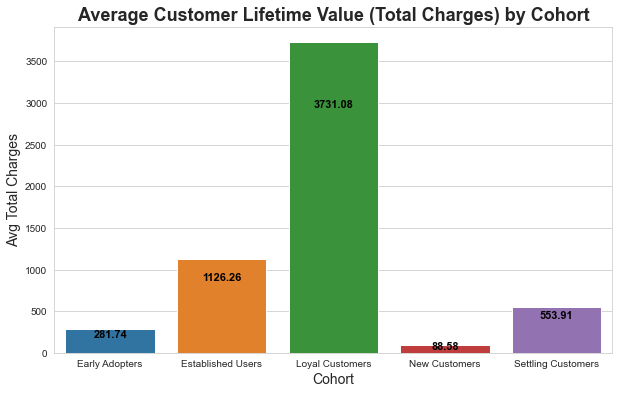

In [27]:
# Calculate average total charges (Customer Lifetime Value) per cohort and round to 2 decimal places
clv_by_cohort = df.groupby('cohort')['total_charges'].mean().round(2).reset_index()

# Set up the plot
plt.figure(figsize=(10, 6))
barplot = sns.barplot(data=clv_by_cohort, x='cohort', y='total_charges', hue='cohort', palette='tab10', dodge=False)

# Add text labels inside bars
for index, row in clv_by_cohort.iterrows():
    barplot.text(
        index,
        row['total_charges'] * 0.8,  # position inside the bar at 90% height
        f"{row['total_charges']:.2f}",
        ha='center',
        va='center',
        fontsize=11,
        fontweight='bold',
        color='black'  # white text for contrast
    )

# Title and labels
plt.title('Average Customer Lifetime Value (Total Charges) by Cohort', fontsize=18, fontweight='bold')
plt.xlabel('Cohort', fontsize=14)
plt.ylabel('Avg Total Charges', fontsize=14)

plt.show()


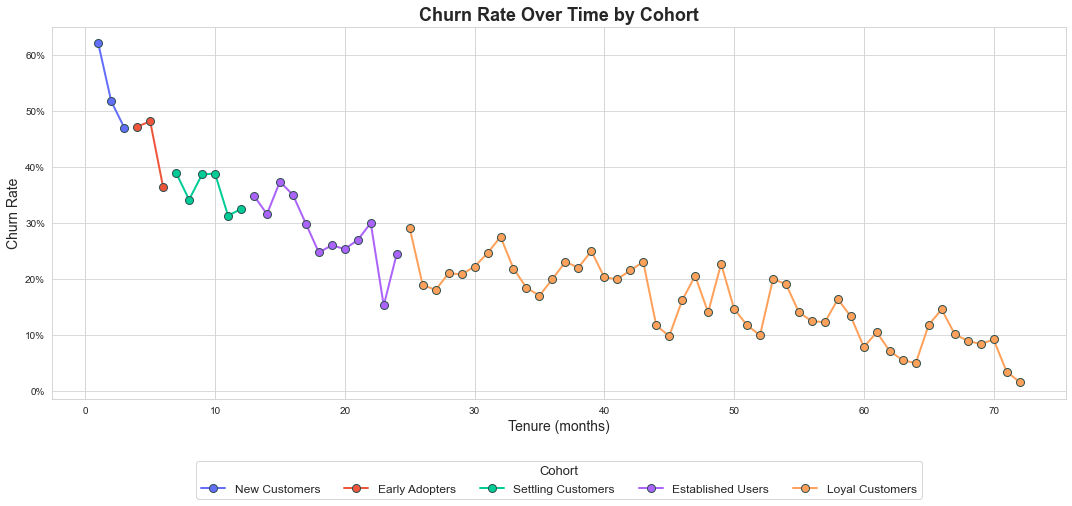

In [28]:
# Calculate churn summary with churn counts, churn rate, and total count
churn_summary = (
    df.groupby(['cohort', 'tenure'])['churn']
    .value_counts()
    .unstack(fill_value=0)
    .rename(columns={'No': 'retained', 'Yes': 'churned'})
    .reset_index()
)

churn_summary['count'] = churn_summary['churned'] + churn_summary['retained']
churn_summary['churn_rate'] = churn_summary['churned'] / churn_summary['count']

# Define custom cohort colors
cohort_colors = {
    'New Customers': '#636EFA',
    'Early Adopters': '#EF553B',
    'Settling Customers': '#00CC96',
    'Established Users': '#AB63FA',
    'Loyal Customers': '#FFA15A'
}

plt.figure(figsize=(15, 7))

# Plot lineplot for each cohort with markers
for cohort, color in cohort_colors.items():
    cohort_data = churn_summary[churn_summary['cohort'] == cohort]
    plt.plot(
        cohort_data['tenure'],
        cohort_data['churn_rate'],
        marker='o',
        markersize=8,
        markeredgewidth=1,
        markeredgecolor='darkslategrey',
        color=color,
        label=cohort,
        linewidth=2
    )

# Format y-axis as percentage
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))

plt.title('Churn Rate Over Time by Cohort', fontsize=18, fontweight='bold')
plt.xlabel('Tenure (months)', fontsize=14)
plt.ylabel('Churn Rate', fontsize=14)
plt.grid(axis='y', color='lightgray')

# Legend below plot, centered
plt.legend(
    title='Cohort',
    fontsize=12,
    title_fontsize=13,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),  # below the plot
    ncol=len(cohort_colors)
)

plt.tight_layout()
plt.subplots_adjust(bottom=0.2)  # increase bottom margin for legend

plt.show()


**📊 Insight:
Over time, the churn rate 📉 decreases. Each successive cohort 👥 shows a lower churn rate than the previous one. The longer customers use the service ⏳, the lower the churn rate within their cohort tends to be.**

**Cohort Conclusions**
- Loyal Customers:
These are long-term users (tenure > 24 months) who demonstrate strong stability and the lowest churn rates. They tend to pay the highest average monthly charges ($70.61), reflecting deeper engagement or premium service usage.

- Established Users:
Customers with 13–24 months tenure who are building loyalty. They show moderate churn risk but are generally stable, with monthly charges higher than newer cohorts ($61.36), indicating growing commitment.

- Settling Customers:
Users with 7–12 months tenure who are still adjusting to the service. They have moderate stability and churn rates, paying an average monthly charge of $58.95.

- Early Adopters:
Customers with 4–6 months tenure, often tech-forward and curious but less committed. Their churn rate is higher compared to more loyal groups, with monthly charges around $58.34.

- New Customers:
The newest users (0–3 months tenure) who are most prone to churn. They pay the lowest monthly charges ($53.44), possibly due to introductory plans or limited usage.

**Overall Insight:**
Churn decreases steadily as customers mature through cohorts and increase their tenure. Longer tenure correlates with higher monthly charges and stronger retention, highlighting the importance of supporting customers early to improve loyalty and lifetime value.


### 🛠️ Feature Importance

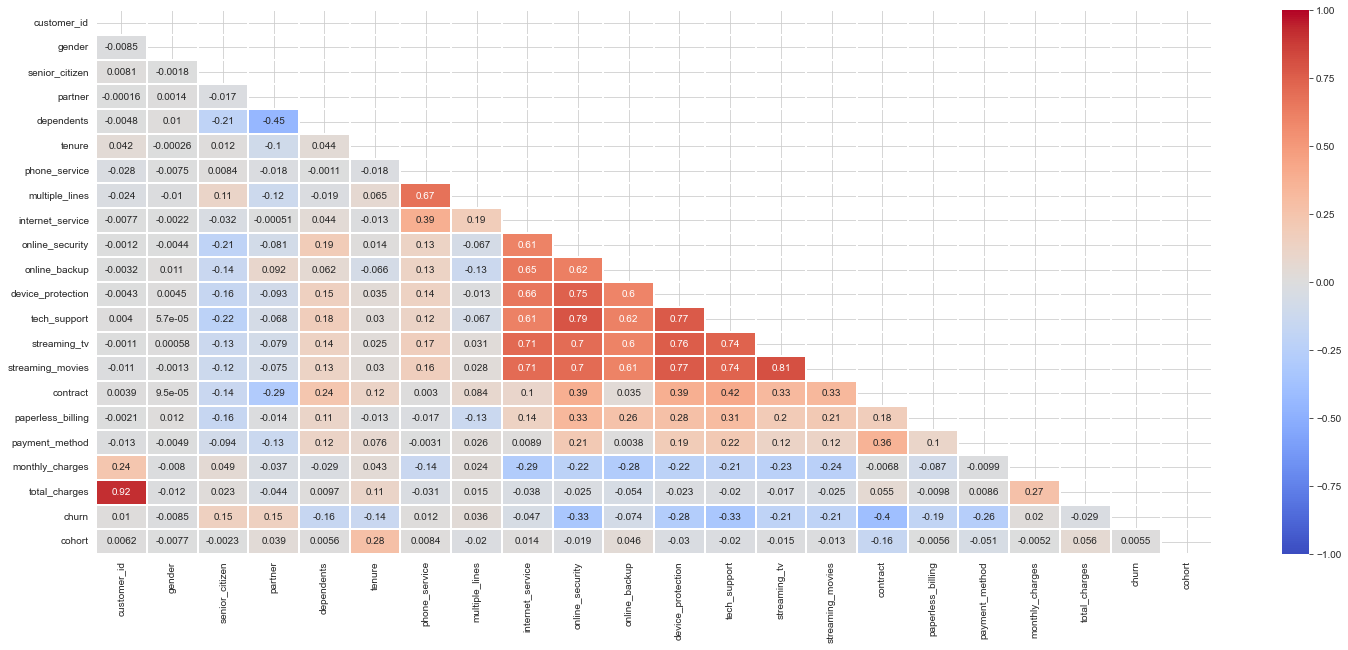

In [32]:
# Correlation between all variables
plt.figure(5, figsize=(25, 10))
corr = df.apply(lambda x: pd.factorize(x)[0]).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
ax = sns.heatmap(corr, mask=mask, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, linewidths=.2, cmap='coolwarm', vmin=-1, vmax=1)

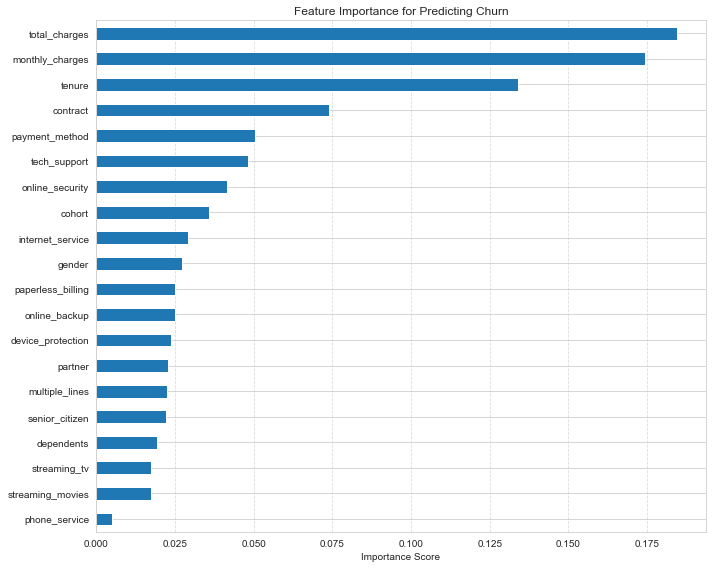

In [33]:
# Copy the original DataFrame
df_model = df.copy()

# Encode categorical features
le = LabelEncoder()
for col in df_model.select_dtypes(include='object'):
    df_model[col] = le.fit_transform(df_model[col])

# Define features and target
X = df_model.drop(columns=['customer_id', 'churn'])
y = df_model['churn']

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# Get feature importances
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=True)  # ascending for horizontal bars

# Plot horizontal bar chart
plt.figure(figsize=(10, 8))
importances.plot(kind='barh')
plt.title('Feature Importance for Predicting Churn')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


**🔍 Feature Importance – Key Insights:**
- Total Charges, Monthly Charges, and Tenure are the most important factors in predicting churn.
- Contract type and payment method also strongly affect whether customers stay or leave.
- Support and security services (like tech support and online security) help reduce churn.
- Basic services like phone or streaming have little impact on churn decisions.
- Demographics (like gender or age) matter less than usage and billing behavior.

## 📥 Outcomes

🔍 Interpretation of Results

1. Critical Churn Periods
- The first 6 months of service show the highest churn.
- **New Customers** (0–3 months) and **Early Adopters** (4–6 months) are most at risk.
- Early disengagement often leads to cancellation before value is realized.

2. Stable vs. High-Risk Cohorts
- Stable: **Loyal Customers** (tenure > 24 months) have low churn and high monthly spend, **Established Users** (13–24 months) are improving in retention but still need nurturing.
- High-Risk: **New and Early Adopters** tend to churn quickly and contribute less revenue, indicating weaker engagement or trial behavior.

4. Key Churn Drivers
- **Short tenure**
- **High monthly charges** without clear value
- **Month-to-month contracts**
- **Lack of support features** (e.g. tech support, online security)

4. Recommendations by Segment
- **New/Early Customers:** Prioritize onboarding and value education.
- **No support features:** Promote bundled add-ons to boost satisfaction.
- **Flexible contract users:** Offer upgrades or discounts to encourage long-term commitment.


**🧠 Conclusion**
- Churn is concentrated early in the customer journey.
- **Tenure**, **total charges**, and **contract type** are top predictors of retention.
- Demographics play a smaller role than service usage and billing behavior.

**💡 Retention Strategies**
- Incentivize early loyalty with welcome offers and onboarding support.
- Promote long-term contracts with added benefits.
- Use churn signals to target at-risk users with timely, personalized offers.


**🚀 Next Steps**
- Launch early-stage retention campaigns.
- Test contract incentives and measure impact.
- Improve onboarding and promote key features.
- Develop predictive churn alerts.
- Track churn, CLV, and engagement to refine strategy.